## <b> Project 3 Part 2: Integer Separation </b>
### Deterministic Methods and Optimization
### Mahmoud El Daou, Joshhua Chen, Jan Kagerhuber, Yutai Ke

In [46]:
from gurobipy import Model, GRB, GurobiError
from graph_tool.generation import complete_graph
from graph_tool.flow import boykov_kolmogorov_max_flow, min_st_cut
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

Same modifications as in Part 2

In [47]:
np.random.seed(1)
N = 20

V = range(N)
xs = np.random.uniform(low=0, high=100, size=N)
ys = np.random.uniform(low=0, high=100, size=N)
profit = np.random.uniform(low=100,high =100,size = N)
profit[0] = 0
T=200

cost = {
    (i, j): sqrt((xs[i] - xs[j]) ** 2 + (ys[i] - ys[j]) ** 2)
    for i in V for j in V if i != j
}

A = list(cost.keys())

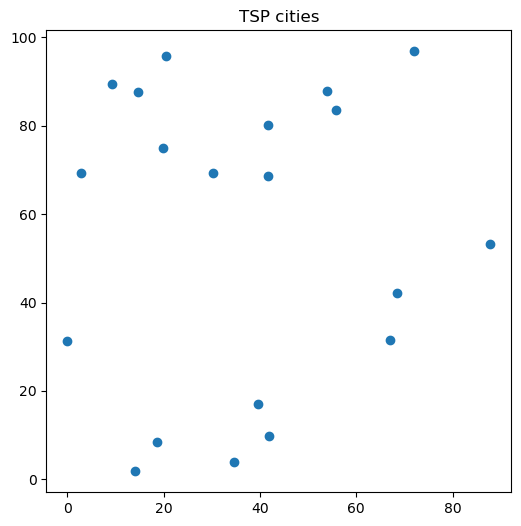

In [48]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(xs, ys)
ax.set_title('TSP cities');

In [49]:
G = complete_graph(N=N, self_loops=False, directed=True)
cap = G.new_edge_property(value_type='double')
G.edge_properties['cap'] = cap

## Creating the Model

Only change we made was setting x to be continuous rather the binary to permit fractional solutions.

In [50]:
m = Model()
x = m.addVars(A, vtype=GRB.CONTINUOUS, name='x')
y = m.addVars(V, vtype=GRB.BINARY, name='y')
m.addConstr(y[0] == 1, name='Include_First')
m.addConstrs((x.sum(i, '*') == y[i] for i in V), name='out_degree')
m.addConstrs((x.sum('*', i) == y[i] for i in V), name = 'in_degree')
m.addConstr(sum(x[i, j] * cost[i, j] for i, j in A) <= T, name='CostConstraint')
m.setObjective(sum(y[i] * profit[i] for i in V) - sum(x[i,j] * cost[i,j] for i,j in A), GRB.MAXIMIZE)
m.setParam(GRB.Param.LazyConstraints, 1)

Set parameter LazyConstraints to value 1


## Running the Model

In [51]:
def set_capacity():
    for e in G.edges():
        i, j = e.source(), e.target()

        try:
            xval = m.cbGetSolution(x[i,j])
        except GurobiError:
            xval = m.cbGetNodeRel(x[i,j])

        cap[e] = xval

In [52]:
def add_sec_for(subtour):
    print('Added a violated SEC')
    for k in subtour:
        m.cbLazy(sum(x[i, j] for i in subtour for j in set(V) - set(subtour)) >= y[k])

In [53]:
def selectedVertices():
    selected = []

    for i in V:
        try:
            if m.cbGetSolution(y[i]) > 0.9:
                selected.append(i)
        except GurobiError:
            if y[i].X > 0.9:
                selected.append(i)
                
    return selected

In [54]:
def callback(what, where):
    if where not in (GRB.Callback.MIPSOL, GRB.Callback.MIPNODE):
        return
    
    if where == GRB.Callback.MIPNODE and m.cbGet(GRB.Callback.MIPNODE_STATUS) != GRB.OPTIMAL:
        return
    
    set_capacity()

    source = G.vertex(0)
    added  = set()

    for i in range(1, N):
        if i in added:
            continue

        sink = G.vertex(i)
        res = boykov_kolmogorov_max_flow(g=G, source=source, target=sink, capacity=cap)

        # Create an edge property map quickly by
        # copying an existing one.
        flow = res.copy()

        # The value held by the property map is in
        # the .a member. Because capacity == flow + residuals
        # we must write:
        flow.a = cap.a - res.a

        maxflow = sum(flow[a] for a in sink.in_edges())

        if maxflow < 1 - 1e-6:
            print(f"Violated SEC. Flow = {maxflow:.3f} < 1")
            cut = min_st_cut(g=G, source=source, capacity=cap, residual=res)

            assert cut[source] == True
            assert cut[sink] == False

            subtour = [j for j in V if cut[G.vertex(j)] == False]

            assert len(subtour) < N

            add_sec_for(subtour)

            added = added.union(subtour)



In [55]:
def subtour_starting_at(vertex):
    tour = [vertex]
    current = next_after(vertex)

    while current != vertex:
        tour.append(current)
        current = next_after(current)

    return tour

In [56]:
def next_after(i):
    for j in V:
        if j == i:
            continue
        try:
            if m.cbGetSolution(x[i, j]) > 0.9:
                return j
        except GurobiError:
            if x[i, j].X > 0.9:
                return j
    
    assert False, f"Vertex {i} has no successor"

In [57]:
m.optimize(callback=callback)

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 42 rows, 400 columns and 1181 nonzeros
Model fingerprint: 0x6671ce60
Variable types: 380 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [5e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Violated SEC. Flow = 0.000 < 1
Added a violated SEC
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 41 rows, 399 columns, 1176 nonzeros
Variable types: 380 continuous, 19 integer (19 binary)

Root relaxation: objective 1.450818e+03, 33 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1450.81805    0    1          - 1450.81805      -     -    0s
Vi

## Solution:

In [61]:
remaining = set(selectedVertices())

total_profit = 0
for vert in remaining:
    total_profit += profit[vert]

first = next(iter(remaining))
all_tours = []
while len(remaining) > 0:
    subtour = subtour_starting_at(vertex=first)
    all_tours.append(subtour)
    remaining -= set(subtour)
    
print(f'Number of selected vertices: {len(selectedVertices())}')

tour = all_tours[0]

Number of selected vertices: 11


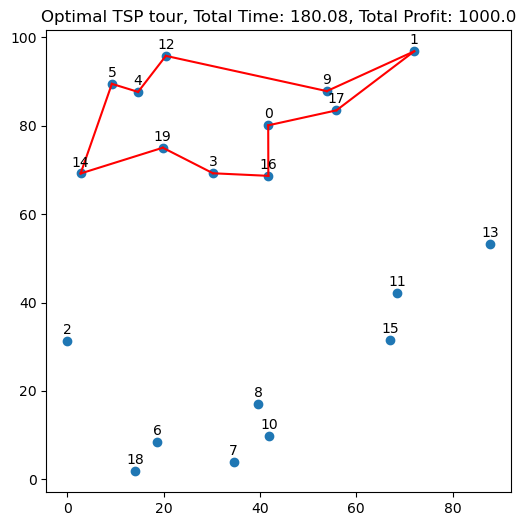

In [62]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(xs, ys)
tour2 = tour[1:] + [0]

tour_path = []

tour_cost = 0
for i, j in zip(tour, tour2):
    ax.plot((xs[i], xs[j]), (ys[i], ys[j]), color='red')
    tour_cost += cost[i, j]

for i, (x_, y_) in enumerate(zip(xs, ys)):
    ax.annotate(str(i), (x_, y_), textcoords="offset points", xytext=(0, 5), ha='center')

ax.set_title(f'Optimal TSP tour, Total Time: {round(tour_cost, 2)}, Total Profit: {round(total_profit, 2)}');

[0, 1, 3, 4, 5, 9, 12, 14, 16, 17, 19]